# Eval Runners

In [1]:
import torch
import torch.nn.functional as F

import pandas as pd
from pandas.io.formats.style import Styler

from IPython.display import display
from sklearn.linear_model import LinearRegression

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

from ood.runner import OODRunner
from ood.metrics import metrics_df
from create_runner import get_fancy_name
from eval_runner import get_last_layer, get_df, observe_ood

## Generate Tables

### Names of weights

In [2]:
with open('./weights.list', 'r') as f:
  names = [w.strip() for w in f.readlines()]
print(names)

['resnet50.A', 'resnet50.B', 'resnet50.C', 'ResNet50_Weights.IMAGENET1K_V1', 'ResNet50_Weights.IMAGENET1K_V2', 'ResNet152_Weights.IMAGENET1K_V1', 'ResNet152_Weights.IMAGENET1K_V2', 'ViT_B_16_Weights.IMAGENET1K_V1', 'ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1', 'ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1', 'Swin_V2_B_Weights.IMAGENET1K_V1', 'MobileNet_V2_Weights.IMAGENET1K_V1', 'MobileNet_V2_Weights.IMAGENET1K_V2', 'MobileNet_V3_Large_Weights.IMAGENET1K_V1', 'MobileNet_V3_Large_Weights.IMAGENET1K_V2', 'AlexNet_Weights.IMAGENET1K_V1', 'ConvNeXt_Base_Weights.IMAGENET1K_V1', 'DenseNet161_Weights.IMAGENET1K_V1', 'EfficientNet_B7_Weights.IMAGENET1K_V1', 'EfficientNet_V2_M_Weights.IMAGENET1K_V1', 'GoogLeNet_Weights.IMAGENET1K_V1', 'Inception_V3_Weights.IMAGENET1K_V1', 'MNASNet1_3_Weights.IMAGENET1K_V1', 'MaxVit_T_Weights.IMAGENET1K_V1', 'RegNet_Y_16GF_Weights.IMAGENET1K_V1', 'RegNet_Y_16GF_Weights.IMAGENET1K_V2', 'RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1', 'RegNet_Y_16GF_Weights.IMAGENET1K_S

In [3]:
lp = {
  'resnet50.A': True,
  'resnet50.B': False,
  'resnet50.C': True,
  'resnet50.V1': False,
  'resnet50.V2': True,
  'resnet152.V1': False,
  'resnet152.V2': True,
  'vit_b_16.V1': True,
  'vit_b_16.SWAG_E2E_V1': True,
  'vit_b_16.SWAG_LINEAR_V1': False,
  'swin_v2_b.V1': True,
  'mobilenet_v2.V1': False,
  'mobilenet_v2.V2': True,
  'mobilenet_v3_large.V1': False,
  'mobilenet_v3_large.V2': True,
  'alexnet.V1': False,
  'convnext_base.V1': True,
  'densenet161.V1': True,
  'efficientnet_b7.V1': False,
  'efficientnet_v2_m.V1': True,
  'googlenet.V1': False,
  'inception_v3.V1': False,
  'mnasnet1_3.V1': True,
  'maxvit_t.V1': True,
  'regnet_y_16gf.V1': False,
  'regnet_y_16gf.V2': True,
  'regnet_y_16gf.SWAG_E2E_V1': True,
  'regnet_y_16gf.SWAG_LINEAR_V1': False,
  'resnext101_32x8d.V1': False,
  'resnext101_32x8d.V2': True,
  'shufflenet_v2_x2_0.V1': True,
  'vgg19_bn.V1': False,
  'wide_resnet101_2.V1': False,
  'wide_resnet101_2.V2': True,
  'eva02.in1k': True,
  'eva02.in22k_in1k': True,
}

len([n for n in lp.keys() if lp.get(n)]), len([n for n in lp.keys() if not lp.get(n)])

(21, 15)

In [4]:
def color_df(df:pd.DataFrame) -> Styler:
  styler = df.style
  if (('MSP', 'FPR@95') in df.columns) or (('TRIM(20,38)', 'FPR@95') in df.columns):
    styler.background_gradient(axis=None, subset=pd.IndexSlice[:,pd.IndexSlice[:, 'FPR@95']], cmap='PuBu', vmin=0, vmax=1)
  if (('MSP', 'AUROC') in df.columns) or (('TRIM(20,38)', 'AUROC') in df.columns):
    styler.background_gradient(axis=None, subset=pd.IndexSlice[:,pd.IndexSlice[:, 'AUROC']], cmap='YlOrRd_r', vmin=0, vmax=1)
  if ('ID', 'Accuracy') in df.columns:
    styler.background_gradient(axis=None, subset=pd.IndexSlice[:,pd.IndexSlice[:, 'Accuracy']], cmap='gray', vmin=0.5, vmax=1)
  return styler

### Read from `./results/`

In [5]:
metrics = {}
id_acc = {}
for name in names:
  fname = get_fancy_name(name)
  with open(f'./results/{fname}.acc') as f:
    acc = float(f.read())
  df = pd.read_csv(f'./results/{fname}.csv', header=[0,1], index_col=0)
  id_acc[fname] = acc
  metrics[fname] = df
  print(fname, f"(Acc: {acc:.6f})")
  display(color_df(df))

resnet50.A (Acc: 0.760000)


resnet50.B (Acc: 0.781140)


resnet50.C (Acc: 0.790200)


resnet50.V1 (Acc: 0.761280)


resnet50.V2 (Acc: 0.808520)


resnet152.V1 (Acc: 0.783160)


resnet152.V2 (Acc: 0.822880)


vit_b_16.V1 (Acc: 0.810680)


vit_b_16.SWAG_E2E_V1 (Acc: 0.852860)


vit_b_16.SWAG_LINEAR_V1 (Acc: 0.818940)


swin_v2_b.V1 (Acc: 0.841340)


mobilenet_v2.V1 (Acc: 0.718800)


mobilenet_v2.V2 (Acc: 0.721420)


mobilenet_v3_large.V1 (Acc: 0.740320)


mobilenet_v3_large.V2 (Acc: 0.752760)


alexnet.V1 (Acc: 0.565180)


convnext_base.V1 (Acc: 0.840600)


densenet161.V1 (Acc: 0.771420)


efficientnet_b7.V1 (Acc: 0.841220)


efficientnet_v2_m.V1 (Acc: 0.851100)


googlenet.V1 (Acc: 0.697860)


inception_v3.V1 (Acc: 0.772980)


mnasnet1_3.V1 (Acc: 0.765060)


maxvit_t.V1 (Acc: 0.837000)


regnet_y_16gf.V1 (Acc: 0.804320)


regnet_y_16gf.V2 (Acc: 0.828920)


regnet_y_16gf.SWAG_E2E_V1 (Acc: 0.860180)


regnet_y_16gf.SWAG_LINEAR_V1 (Acc: 0.839280)


resnext101_32x8d.V1 (Acc: 0.793100)


resnext101_32x8d.V2 (Acc: 0.828300)


shufflenet_v2_x2_0.V1 (Acc: 0.762280)


vgg19_bn.V1 (Acc: 0.742180)


wide_resnet101_2.V1 (Acc: 0.788420)


wide_resnet101_2.V2 (Acc: 0.825040)


eva02.in1k (Acc: 0.895780)


eva02.in22k_in1k (Acc: 0.900540)


### Average over OOD datasets

In [6]:
df_avg = pd.DataFrame({k: v.loc[observe_ood].mean()for k,v in metrics.items()}).T
df_avg[('ID', 'Accuracy')] = id_acc
df_avg[('lp','lp')] = lp
color_df(df_avg)

In [7]:
df_fpr95 = df_avg.loc[:, pd.IndexSlice[:,['lp', 'FPR@95', 'Accuracy']]]
color_df(df_fpr95)

Method,lp,MSP,Energy,DICE,ASH_S,TRIM,ID
Metric,lp,FPR@95,FPR@95,FPR@95,FPR@95,FPR@95,Accuracy
resnet50.A,True,0.742160,0.839671,0.980260,0.851333,0.797577,0.760000
resnet50.B,False,0.694502,0.648507,0.620586,0.394424,0.694084,0.781140
resnet50.C,True,0.719949,0.810160,0.977480,0.906130,0.737456,0.790200
resnet50.V1,False,0.709811,0.658076,0.533763,0.364854,0.752663,0.761280
resnet50.V2,True,0.734545,0.960842,0.991577,0.812079,0.710147,0.808520
resnet152.V1,False,0.676962,0.595121,0.516935,0.352193,0.684348,0.783160
resnet152.V2,True,0.674842,0.826658,0.960030,0.787903,0.632285,0.822880
vit_b_16.V1,True,0.664129,0.703464,0.823982,0.996281,0.650796,0.810680
vit_b_16.SWAG_E2E_V1,True,0.536060,0.439704,0.912813,0.935806,0.477647,0.852860


In [8]:
df_auroc = df_avg.loc[:, pd.IndexSlice[:,['lp', 'AUROC', 'Accuracy']]]
color_df(df_auroc)

Method,lp,MSP,Energy,DICE,ASH_S,TRIM,ID
Metric,lp,AUROC,AUROC,AUROC,AUROC,AUROC,Accuracy
resnet50.A,True,0.735993,0.663456,0.450503,0.630158,0.775378,0.760000
resnet50.B,False,0.797445,0.829003,0.805187,0.897313,0.829239,0.781140
resnet50.C,True,0.765436,0.713759,0.372657,0.580807,0.803605,0.790200
resnet50.V1,False,0.739684,0.795263,0.809509,0.897935,0.776882,0.761280
resnet50.V2,True,0.751260,0.500092,0.382627,0.584286,0.829455,0.808520
resnet152.V1,False,0.783542,0.837687,0.834548,0.909169,0.824256,0.783160
resnet152.V2,True,0.788772,0.663224,0.392849,0.586727,0.848014,0.822880
vit_b_16.V1,True,0.792354,0.708634,0.755752,0.181096,0.852309,0.810680
vit_b_16.SWAG_E2E_V1,True,0.850396,0.863666,0.581499,0.570228,0.890282,0.852860


## Accuracy vs. Metrics

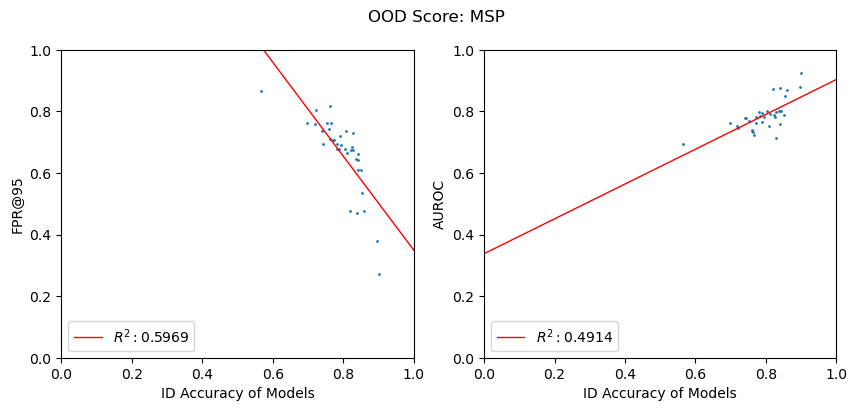

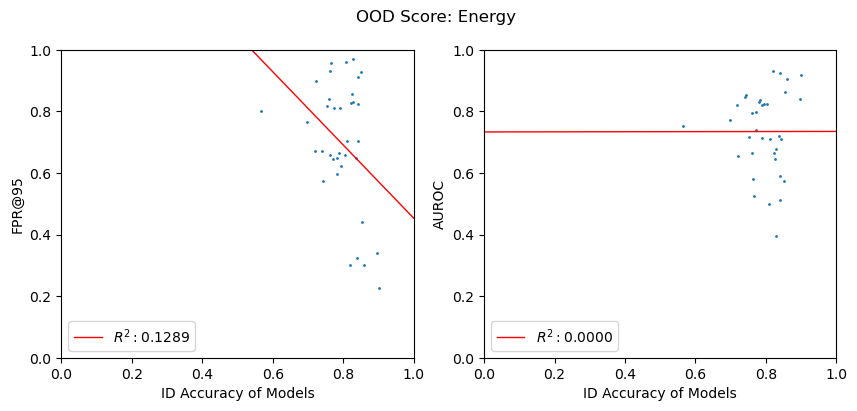

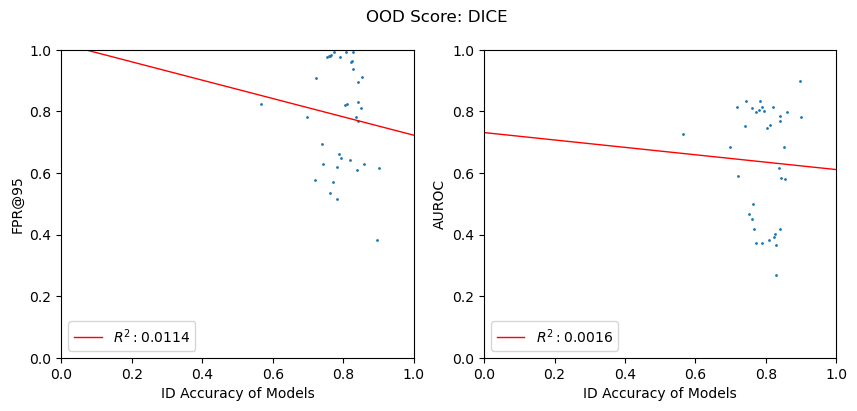

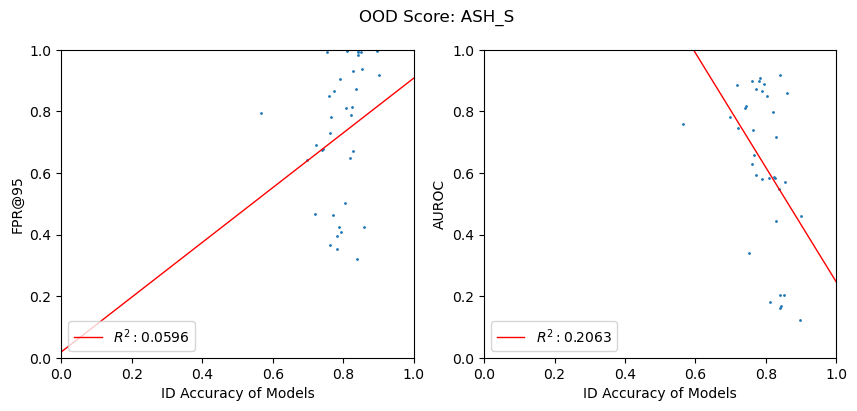

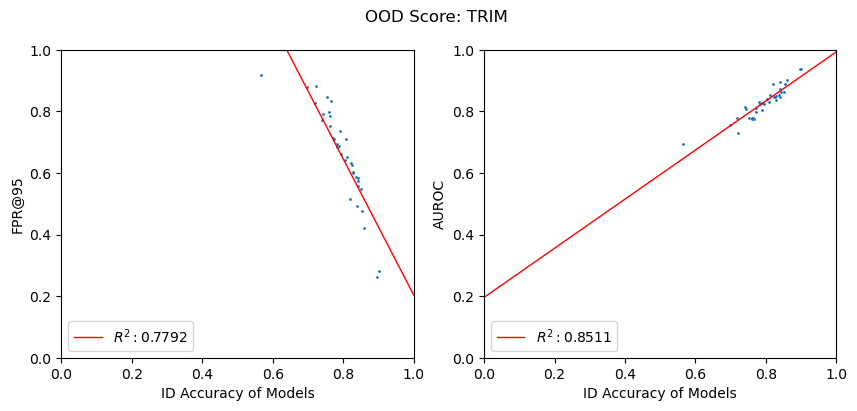

In [9]:
R2 = {}
for score in ['MSP', 'Energy', 'DICE', 'ASH_S', 'TRIM']:
  fig = plt.figure(figsize=(10,4))
  fig.suptitle(f'OOD Score: {score}')
  _R2 = {}
  for i, metric in enumerate(['FPR@95', 'AUROC']):
    x = df_avg[('ID', 'Accuracy')].to_numpy()[:,np.newaxis]
    y = df_avg[(score, metric)].to_numpy()[:,np.newaxis]
    lin_reg = LinearRegression()
    lin_reg.fit(x,y)

    plt.subplot(int(f'12{i+1}'))
    plt.xlabel('ID Accuracy of Models')
    plt.ylabel(metric)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.scatter(x,y, s=1)
    _x = np.array([[0],[1]])
    _R2[metric] = lin_reg.score(x,y)
    plt.plot(_x, lin_reg.predict(_x), label=f'$R^2:{lin_reg.score(x,y):.4f}$', linewidth=1, c='red')
    plt.legend(loc='lower left')
  plt.show()
  R2[score] = _R2

In [10]:
pd.DataFrame(R2).style.background_gradient(axis=None, cmap='RdPu_r', vmin=0, vmax=1)

,MSP,Energy,DICE,ASH_S,TRIM
FPR@95,0.596858,0.128892,0.011422,0.059594,0.779180
AUROC,0.491437,0.000001,0.001606,0.206328,0.851099


## Distribution of top-5 softmax probabilities

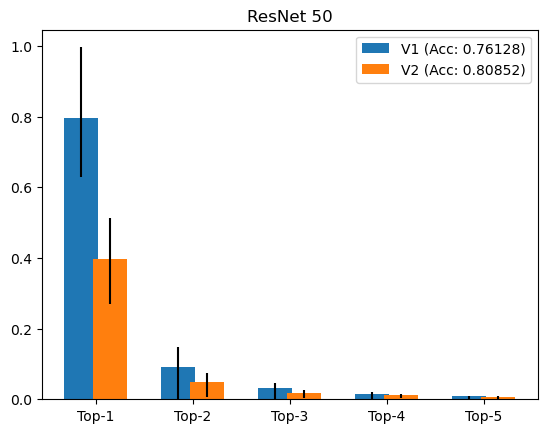

In [11]:
plt.title("ResNet 50")

x_axis = np.arange(5)

runner_v1 = OODRunner('./runners/resnet50.V1.pt')
runner_v2 = OODRunner('./runners/resnet50.V2.pt')

v = F.softmax(runner_v1.id_recorder.compute()['_logit'], dim=-1).sort(axis=-1, descending=True)[0][:,:5]
m = v.mean(axis=0).numpy()
q1 = np.percentile(v, 25, axis=0)
q3 = np.percentile(v, 75, axis=0)
plt.bar(x_axis-0.15, m, 0.35, yerr=np.stack([m-q1, q3-m]), label=f"V1 (Acc: {df_avg.loc['resnet50.V1', ('ID', 'Accuracy')]:.5f})")

v = F.softmax(runner_v2.id_recorder.compute()['_logit'], dim=-1).sort(axis=-1, descending=True)[0][:,:5]
m = v.mean(axis=0).numpy()
q1 = np.percentile(v, 25, axis=0)
q3 = np.percentile(v, 75, axis=0)
plt.bar(x_axis+0.15, m, 0.35, yerr=np.stack([m-q1, q3-m]), label=f"V2 (Acc: {df_avg.loc['resnet50.V2', ('ID', 'Accuracy')]:.5f})")

plt.xticks(x_axis, [f'Top-{i+1}' for i in range(5)])
plt.legend()
plt.show()

## Variations of TRIM-BASE

In [12]:
from tqdm.auto import tqdm
from ood.scores import trim
from eval_runner import observe_ood, observe_metric

_trim_lst = ['TRIM(20,38)', 'TRIM(7,18)', 'TRIM(5,17)']

def get_df(runner:OODRunner, last_layer:torch.nn.Linear) -> tuple[float, pd.DataFrame]:
  ret = {}
  _true = runner.id_recorder.compute()['_class']
  _pred = runner.id_recorder.compute()['_logit'].max(dim=-1)[1]
  id_acc = (_true == _pred).type(torch.float).mean().item()

  _t = (20, 38)
  _df = metrics_df(runner, lambda x: trim(x, _t[0]-1, _t[1])).loc[observe_ood, observe_metric]
  _idx = pd.MultiIndex.from_tuples([(f'TRIM({_t[0]},{_t[1]})', 'FPR@95'), (f'TRIM({_t[0]},{_t[1]})', 'AUROC')], names=('Method', 'Metric'))
  _df.columns = _idx
  ret[str(_t)] = _df.copy()

  _t = (7, 18)
  _df = metrics_df(runner, lambda x: trim(x, _t[0]-1, _t[1])).loc[observe_ood, observe_metric]
  _idx = pd.MultiIndex.from_tuples([(f'TRIM({_t[0]},{_t[1]})', 'FPR@95'), (f'TRIM({_t[0]},{_t[1]})', 'AUROC')], names=('Method', 'Metric'))
  _df.columns = _idx
  ret[str(_t)] = _df.copy()

  _t = (5, 17)
  _df = metrics_df(runner, lambda x: trim(x, _t[0]-1, _t[1])).loc[observe_ood, observe_metric]
  _idx = pd.MultiIndex.from_tuples([(f'TRIM({_t[0]},{_t[1]})', 'FPR@95'), (f'TRIM({_t[0]},{_t[1]})', 'AUROC')], names=('Method', 'Metric'))
  _df.columns = _idx
  ret[str(_t)] = _df.copy()

  return id_acc, pd.concat(ret.values(), axis=1)

### (Optional) Calculate from Runners

If you don't want to read from text files in `./results/`, then you can make the tabels from the runners directly.
It will takes some time.

It is equivalent to run `eval_runner.py`

In [13]:
for name in tqdm(names):
  fname = get_fancy_name(name)
  runner = OODRunner(f'./runners/{fname}.pt')
  last_layer = get_last_layer(name)

  acc, df = get_df(runner, last_layer)
  metrics[fname] = pd.concat([metrics[fname],df], axis=1)
  id_acc[fname] = acc
  print(fname, f"(Acc: {acc:.6f})")
  display(color_df(df))
  del runner

  0%|          | 0/36 [00:00<?, ?it/s]

resnet50.A (Acc: 0.760000)


resnet50.B (Acc: 0.781140)


resnet50.C (Acc: 0.790200)


resnet50.V1 (Acc: 0.761280)


resnet50.V2 (Acc: 0.808520)


resnet152.V1 (Acc: 0.783160)


resnet152.V2 (Acc: 0.822880)


vit_b_16.V1 (Acc: 0.810680)


vit_b_16.SWAG_E2E_V1 (Acc: 0.852860)


vit_b_16.SWAG_LINEAR_V1 (Acc: 0.818940)


swin_v2_b.V1 (Acc: 0.841340)


mobilenet_v2.V1 (Acc: 0.718800)


mobilenet_v2.V2 (Acc: 0.721420)


mobilenet_v3_large.V1 (Acc: 0.740320)


mobilenet_v3_large.V2 (Acc: 0.752760)


alexnet.V1 (Acc: 0.565180)


convnext_base.V1 (Acc: 0.840600)


densenet161.V1 (Acc: 0.771420)


efficientnet_b7.V1 (Acc: 0.841220)


efficientnet_v2_m.V1 (Acc: 0.851100)


googlenet.V1 (Acc: 0.697860)


inception_v3.V1 (Acc: 0.772980)


mnasnet1_3.V1 (Acc: 0.765060)


/home/bckim/miniconda3/envs/pytorch_jax/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


maxvit_t.V1 (Acc: 0.837000)


regnet_y_16gf.V1 (Acc: 0.804320)


regnet_y_16gf.V2 (Acc: 0.828920)


regnet_y_16gf.SWAG_E2E_V1 (Acc: 0.860180)


regnet_y_16gf.SWAG_LINEAR_V1 (Acc: 0.839280)


resnext101_32x8d.V1 (Acc: 0.793100)


resnext101_32x8d.V2 (Acc: 0.828300)


shufflenet_v2_x2_0.V1 (Acc: 0.762280)


vgg19_bn.V1 (Acc: 0.742180)


wide_resnet101_2.V1 (Acc: 0.788420)


wide_resnet101_2.V2 (Acc: 0.825040)


eva02.in1k (Acc: 0.895780)


eva02.in22k_in1k (Acc: 0.900540)


In [14]:
df_avg = pd.DataFrame({k: v.loc[observe_ood].mean()for k,v in metrics.items()}).T
df_avg[('ID', 'Accuracy')] = id_acc
df_avg[('lp','lp')] = lp
color_df(df_avg)

In [15]:
df_fpr95 = df_avg.loc[:, pd.IndexSlice[:,['FPR@95', 'Accuracy']]]
color_df(df_fpr95[['TRIM']+_trim_lst])

Method,TRIM,"TRIM(20,38)","TRIM(7,18)","TRIM(5,17)"
Metric,FPR@95,FPR@95,FPR@95,FPR@95
resnet50.A,0.797577,0.726159,0.777742,0.806201
resnet50.B,0.694084,0.650438,0.681291,0.702875
resnet50.C,0.737456,0.679275,0.718693,0.745700
resnet50.V1,0.752663,0.683523,0.731380,0.760022
resnet50.V2,0.710147,0.656207,0.691147,0.717265
resnet152.V1,0.684348,0.622794,0.663685,0.692998
resnet152.V2,0.632285,0.592938,0.617848,0.636676
vit_b_16.V1,0.650796,0.597547,0.637159,0.661197
vit_b_16.SWAG_E2E_V1,0.477647,0.406473,0.460712,0.488904


In [16]:
diff_df_fpr95 = df_fpr95[_trim_lst] - df_fpr95['TRIM']
col_idx = pd.MultiIndex.from_tuples([(t, 'FPR@95') for t in _trim_lst], names=('Method', 'Metric'))
diff_df_fpr95.columns = col_idx
diff_df_fpr95.loc['Avg.'] = diff_df_fpr95.mean()
diff_df_fpr95.loc['Std.'] = diff_df_fpr95.std()
diff_df_fpr95.style.background_gradient(axis=None, cmap='PuBu')

Method,"TRIM(20,38)","TRIM(7,18)","TRIM(5,17)"
Metric,FPR@95,FPR@95,FPR@95
resnet50.A,-0.071418,-0.019835,0.008624
resnet50.B,-0.043646,-0.012792,0.008792
resnet50.C,-0.058180,-0.018763,0.008244
resnet50.V1,-0.069139,-0.021283,0.007359
resnet50.V2,-0.053941,-0.019000,0.007118
resnet152.V1,-0.061554,-0.020663,0.008651
resnet152.V2,-0.039346,-0.014437,0.004391
vit_b_16.V1,-0.053249,-0.013637,0.010401
vit_b_16.SWAG_E2E_V1,-0.071174,-0.016935,0.011257


In [17]:
df_auroc = df_avg.loc[:, pd.IndexSlice[:,['AUROC', 'Accuracy']]]
color_df(df_auroc[['TRIM']+_trim_lst])

Method,TRIM,"TRIM(20,38)","TRIM(7,18)","TRIM(5,17)"
Metric,AUROC,AUROC,AUROC,AUROC
resnet50.A,0.775378,0.778602,0.779277,0.772936
resnet50.B,0.829239,0.841986,0.832474,0.826984
resnet50.C,0.803605,0.803659,0.806154,0.801797
resnet50.V1,0.776882,0.797976,0.782023,0.773351
resnet50.V2,0.829455,0.829288,0.832925,0.828016
resnet152.V1,0.824256,0.843584,0.828878,0.820976
resnet152.V2,0.848014,0.841489,0.849749,0.846449
vit_b_16.V1,0.852309,0.849245,0.855250,0.849671
vit_b_16.SWAG_E2E_V1,0.890282,0.896253,0.893367,0.887588


In [18]:
diff_df_auroc = df_auroc[_trim_lst] - df_auroc['TRIM']
col_idx = pd.MultiIndex.from_tuples([(t, 'AUROC') for t in _trim_lst], names=('Method', 'Metric'))
diff_df_auroc.columns = col_idx
diff_df_auroc.loc['Avg.'] = diff_df_auroc.mean()
diff_df_auroc.loc['Std.'] = diff_df_auroc.std()
diff_df_auroc.style.background_gradient(axis=None, cmap='YlOrRd_r')

Method,"TRIM(20,38)","TRIM(7,18)","TRIM(5,17)"
Metric,AUROC,AUROC,AUROC
resnet50.A,0.003224,0.003899,-0.002442
resnet50.B,0.012747,0.003236,-0.002255
resnet50.C,0.000055,0.002549,-0.001807
resnet50.V1,0.021094,0.005141,-0.003530
resnet50.V2,-0.000168,0.003469,-0.001440
resnet152.V1,0.019329,0.004622,-0.003280
resnet152.V2,-0.006525,0.001735,-0.001565
vit_b_16.V1,-0.003064,0.002941,-0.002638
vit_b_16.SWAG_E2E_V1,0.005972,0.003086,-0.002694


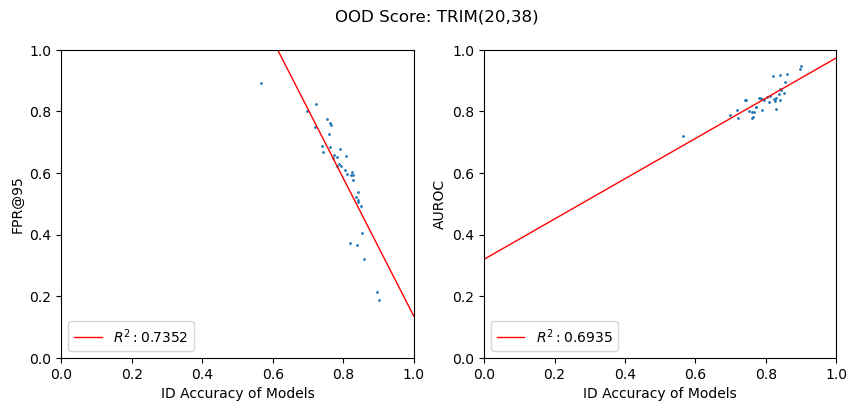

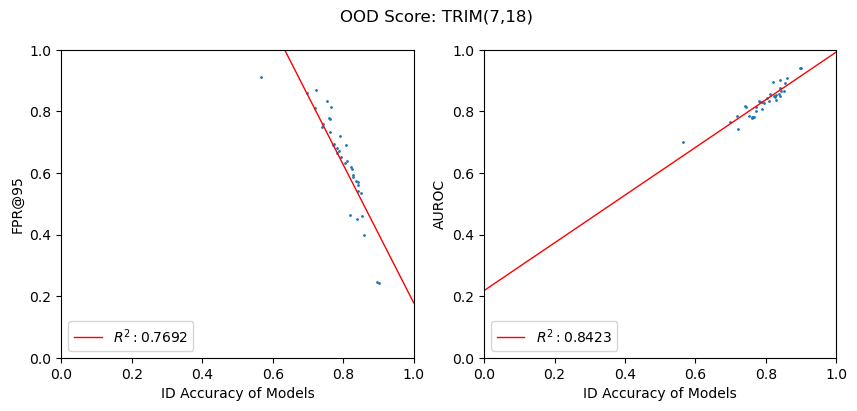

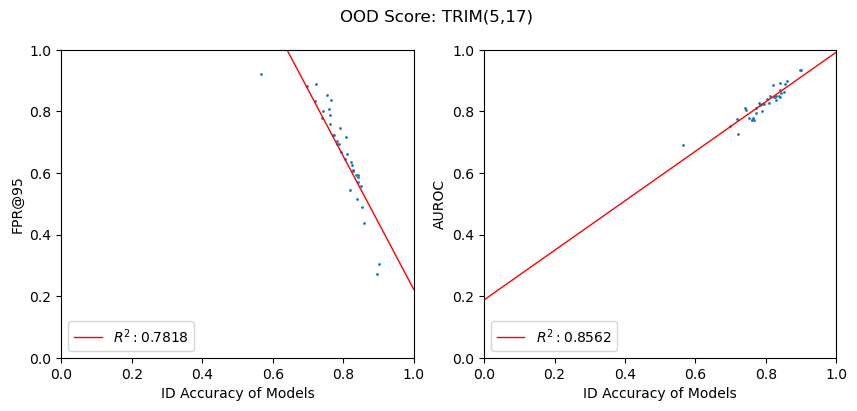

In [19]:
for score in _trim_lst:
  fig = plt.figure(figsize=(10,4))
  fig.suptitle(f'OOD Score: {score}')
  _R2 = {}
  for i, metric in enumerate(['FPR@95', 'AUROC']):
    x = df_avg[('ID', 'Accuracy')].to_numpy()[:,np.newaxis]
    y = df_avg[(score, metric)].to_numpy()[:,np.newaxis]
    lin_reg = LinearRegression()
    lin_reg.fit(x,y)

    plt.subplot(int(f'12{i+1}'))
    plt.xlabel('ID Accuracy of Models')
    plt.ylabel(metric)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.scatter(x,y, s=1)
    _x = np.array([[0],[1]])
    _R2[metric] = lin_reg.score(x,y)
    plt.plot(_x, lin_reg.predict(_x), label=f'$R^2:{lin_reg.score(x,y):.4f}$', linewidth=1, c='red')
    plt.legend(loc='lower left')
  plt.show()
  R2[score] = _R2

In [20]:
df = pd.DataFrame(R2)
df.index = ['R^2 (FPR@95)', 'R^2 (AUROC)']
df.loc['FPR@95'] = df_fpr95.loc[:, pd.IndexSlice[:,['FPR@95']]].mean().to_numpy()
df.loc['AUROC'] = df_auroc.loc[:, pd.IndexSlice[:,['AUROC']]].mean().to_numpy()
df.loc[['FPR@95', 'AUROC', 'R^2 (FPR@95)', 'R^2 (AUROC)']].style.background_gradient(axis=None, cmap='RdPu_r', subset=pd.IndexSlice[['R^2 (FPR@95)', 'R^2 (AUROC)'],:], vmin=0, vmax=1).background_gradient(axis=None, subset=pd.IndexSlice['FPR@95',:], cmap='PuBu', vmin=0, vmax=1).background_gradient(axis=None, subset=pd.IndexSlice['AUROC',:], cmap='YlOrRd_r', vmin=0, vmax=1)

,MSP,Energy,DICE,ASH_S,TRIM,"TRIM(20,38)","TRIM(7,18)","TRIM(5,17)"
FPR@95,0.664072,0.698202,0.783921,0.724342,0.659202,0.597095,0.640840,0.668171
AUROC,0.786691,0.734364,0.635615,0.628829,0.828891,0.838755,0.833079,0.826385
R^2 (FPR@95),0.596858,0.128892,0.011422,0.059594,0.779180,0.735198,0.769221,0.781787
R^2 (AUROC),0.491437,0.000001,0.001606,0.206328,0.851099,0.693509,0.842338,0.856204
